.. meta::
   :description: Using the responsible AI toolbox to build workflows.

> Copyright (c) 2022 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 



# Building a Workflows for Cross Validation and Adversarial Robustness
This notebook demonstrates how the to build experiment workflows for configurable, repeatable, and scalable (CRS) experimentation. Two basic workflows will be demonstrated in this tutorial:

- Cross-Validation Workflow: Performs cross-validation training that logs accuracy and loss across data folds
- Robustness Curve Workflow: Loads a trained model and assesses the impact of adversarial perturbations on the model's performance; the model's performance metric is plotted against the increasing "severity" of the perturbation

Here, "workflow" has a precise meaning. In the parlance of [mushin](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/ref_mushin.html) a workflow is an API for describing how we configure, launch, and post-process one or more tasks. These workflows leverage [Hydra](https://hydra.cc/) and [hydra-zen](https://github.com/mit-ll-responsible-ai/hydra-zen) so that they are highly configurable and so that each job launched by a workflow is self-documenting and reproducible. 
In this tutorial, we also make use of [PyTorch Lightning](https://www.pytorchlightning.ai/) to eliminate boilerplate code associated with training and testing a PyTorch model.

## Getting Started


We will install the rAI-toolbox and then we will create a Jupyter notebook in which we will complete this tutorial.


### Installing `rai_toolbox`


To install the toolbox (along with its `mushin` capabilities) in your Python environment, run the following command in your 
terminal:

```console
$ pip install rai-toolbox[mushin]
```

To verify that the toolbox is installed as-expected, open a Python console and try 
importing ``rai_toolbox``.

```python
>>> import rai_toolbox
```

You will also need to install scikit-learn; please follow [these instructions](https://scikit-learn.org/stable/install.html#installing-scikit-learn).


## Opening a Jupyter notebook

If you do not have Jupyter Notebook or Jupyter Lab installed in your Python environment, please follow [these instructions](https://jupyter.org/install).
Now open a terminal on your computer and [start a notebook/lab session](http://www.pythonlikeyoumeanit.com/Module1_GettingStartedWithPython/Jupyter_Notebooks.html).
A file-viewer will open in an internet browser; pick a directory where you are okay with saving some PyTorch model weights. Create a notebook called `Building-Workflows.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

Note: you may also need to install the `ipywidgets` package in your Python environment to configure the notebook to  display ipywidgets:

```console
$ pip install ipywidgets
```

## Imports

In [1]:
from pathlib import Path
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import torch as tr

In [2]:
# Hydra and hydra-zen
from hydra.core.config_store import ConfigStore
from hydra_zen import MISSING, builds, instantiate, load_from_yaml, make_config

# Lightning
from pytorch_lightning import LightningModule, Trainer

# sklearn and torch
from sklearn.model_selection import StratifiedKFold
from torch import Tensor, nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# rAI-toolbox
from rai_toolbox._typing import Partial
from rai_toolbox.mushin import load_from_checkpoint
from rai_toolbox.mushin.lightning import MetricsCallback
from rai_toolbox.mushin.workflows import (
    MultiRunMetricsWorkflow,
    RobustnessCurve,
    multirun,
)

from rai_toolbox.optim import L2ProjectedOptim, LinfProjectedOptim
from rai_toolbox.perturbations import gradient_ascent

## Experiment Functions and Classes

Here we define two Neural Network models, a fully linear neural network and a convolutional neural network.

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)



Next lets define a function that takes the `MNIST` dataset and splits the data into training and validation sets using SciKit-Learn's [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).  This allows us to split the dataset into "folds" and select the fold for each experiment.

In [4]:
def split_dataset(
    dataset: MNIST, n_splits: int, fold: int, random_state: int = 49
) -> Tuple[Subset, Subset]:
    """Provide training and validation splits using `sklearn.model_selection.StratifiedKfold`"""

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_indices, val_indices = list(
        kfold.split(range(len(dataset)), dataset.targets)
    )[fold]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)


Now define the [LightningModule](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule) for training and testing.

In [5]:
class StandardModule(LightningModule):
    def __init__(
        self,
        *,
        model: nn.Module,
        dataset: MNIST,
        optimizer: Optional[Partial[Optimizer]] = None,
        perturber=None,
        fold: int = 0,
        n_splits: int = 5,
        batch_size: int = 100,
        num_workers: int = 4,
    ) -> None:
        super().__init__()
        self.dataset = dataset
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.perturber = perturber
        self.n_splits = n_splits
        self.fold = fold
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Metrics
        self.acc_metric = Accuracy()
        if self.perturber:
            self.clean_acc_metric = Accuracy()

    def forward(self, data: Tensor) -> Tensor:
        return self.model(data)

    def train_dataloader(self) -> DataLoader:
        train_dataset, _ = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        _, val_dataset = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(
            val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def configure_optimizers(self) -> Optional[Optimizer]:
        if self.optimizer:
            return self.optimizer(self.model.parameters())
        return None

    def _step(self, batch, stage: str) -> Tensor:
        data_orig, target = batch

        if self.perturber:
            with tr.no_grad():
                output = self.model(data_orig)
                loss = self.criterion(output, target)
                acc = self.clean_acc_metric(output, target)
                self.log(f"{stage}_clean_accuracy", acc)

            data, adv_loss = self.perturber(
                model=self.model, data=data_orig, target=target
            )
            self.log(f"{stage}_adversarial_loss", adv_loss.mean().item())

        else:
            data = data_orig

        output = self.model(data)
        loss = self.criterion(output, target)
        acc = self.acc_metric(output, target)
        self.log(f"{stage}_loss", loss)
        self.log(f"{stage}_accuracy", acc)
        return loss

    def training_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "test")


## hydra-zen Configuration

Now that we have our models lets setup the configurations for our experiments.

In [6]:
Augmentations = builds(
    transforms.Compose,
    [builds(transforms.RandomCrop, size=28, padding=4), builds(transforms.ToTensor)],
)
TrainDataset = builds(MNIST, root="${data_dir}", train=True, transform=Augmentations)
TestDataset = builds(
    MNIST, root="${data_dir}", train=False, transform=builds(transforms.ToTensor)
)
ConvModelCfg = builds(ConvModel)
LinearModelCfg = builds(LinearModel)
Optim = builds(tr.optim.SGD, lr=0.1, zen_partial=True)


L2PGD = builds(L2ProjectedOptim, zen_partial=True)
LinfPGD = builds(LinfProjectedOptim, zen_partial=True)


def lr_for_pgd(epsilon, num_steps):
    return 2.5 * epsilon / num_steps


Perturber = builds(
    gradient_ascent,
    optimizer="${optimizer}",
    epsilon="${epsilon}",
    steps="${steps}",
    lr=builds(lr_for_pgd, "${epsilon}", "${steps}"),
    zen_partial=True,
    populate_full_signature=True,
)

PLModule = builds(
    StandardModule,
    model="${model}",
    fold="${fold}",
    n_splits="${n_splits}",
    dataset=TrainDataset,
    optimizer=Optim,
    perturber="${perturber}",
    populate_full_signature=True,
)


EvalPLModule = builds(
    StandardModule,
    model="${model}",
    dataset=TestDataset,
    perturber="${perturber}",
    populate_full_signature=True,
)


TrainerCfg = builds(
    Trainer,
    max_epochs=10,
    accelerator="auto",
    devices=1,
    enable_progress_bar=False,
    enable_model_summary=False,
    callbacks=[builds(MetricsCallback)],
    populate_full_signature=True,
)


Now we use Hydra's [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) API to create named configuration groups that can be specified/swapped when we run our workflow.

In [7]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="linear", group="model", node=LinearModelCfg)
cs.store(name="l2pgd", group="optimizer", node=L2PGD)
cs.store(name="linfpgd", group="optimizer", node=LinfPGD)


## Cross Validation Workflow

With all the configurations in place we can now define our first experiment workflow: train multiple models on `MNIST` data using cross-validation.  First define the main experiment configuration:

In [8]:
Config = make_config(
    defaults=[
        "_self_",
        {"model": "linear"},
    ],
    data_dir="${oc.env:HOME}/.torch/data",
    model=MISSING,
    module=PLModule,
    trainer=TrainerCfg,
    perturber=None,
    fold=0,
    n_splits=5,
)


Create `CrossValWorkflow` by inheriting from [MultiRunMetricsWorkflow](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MultiRunMetricsWorkflow.html) to train a given model for a given a cross validation dataset (fold).  The task function simply runs PyTorch Lightning's [Trainer.fit](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and returns the metrics saved from [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html).  To run this workflow simply define the number of cross validation splits to use via `n_splits`.

In [9]:
class CrossValWorkFlow(MultiRunMetricsWorkflow):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.fit(module)
        return tr.load("fit_metrics.pt")

    def run(self, n_splits: int, **run_kwargs):
        fold = multirun(range(n_splits))
        super().run(n_splits=n_splits, fold=fold, **run_kwargs)


Now run the workflow by defining the requried `n_splits` and the models (names defined in the [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) above).  Additionally we define the working directory of the experiment by setting `hydra.sweep.dir` configuration via `overrides`.

In [10]:
kfold_task = CrossValWorkFlow(Config)
kfold_task.run(
    n_splits=2,
    model=multirun(["linear", "cnn"]),
    overrides=[
        "hydra.sweep.dir=outputs/cross_validation/${now:%Y-%m-%d}/${now:%H-%M-%S}"
    ],
)
## You can load previous experiments
# kfold_task = CrossValWorkFlow().load_from_dir("outputs/cross_validation/2022-05-11/14-42-14", metrics_filename="fit_metrics.pt")


[2022-05-13 18:08:27,893][HYDRA] Launching 4 jobs locally
[2022-05-13 18:08:27,893][HYDRA] 	#0 : n_splits=2 fold=0 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ry26099/miniconda3/envs/foolme/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,

[2022-05-13 18:09:05,793][HYDRA] 	#1 : n_splits=2 fold=0 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[2022-05-13 18:09:41,277][HYDRA] 	#2 : n_splits=2 fold=1 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[2022-05-13 18:10:14,888][HYDRA] 	#3 : n_splits=2 fold=1 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [11]:
kfold_task.working_dir

PosixPath('/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27')

Once the task is finished we can load in the metrics to an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) using the `to_xarray` method.

In [12]:
xdata = kfold_task.to_xarray(coord_from_metrics="epoch")
xdata

<xarray.Dataset>
Dimensions:         (fold: 2, model: 2, epoch: 10)
Coordinates:
  * fold            (fold) int64 0 1
  * model           (model) <U6 'linear' 'cnn'
  * epoch           (epoch) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    train_loss      (fold, model, epoch) float64 1.843 0.9141 ... 0.01429
    train_accuracy  (fold, model, epoch) float64 0.34 0.67 0.84 ... 0.98 1.0
    val_loss        (fold, model, epoch) float64 1.751 0.982 ... 0.05559 0.05875
    val_accuracy    (fold, model, epoch) float64 0.3953 0.6775 ... 0.9822 0.9809
Attributes:
    n_splits:  2

We can use xarray to plot the validation accuracy over training epochs for each fold or aggregrate the mean across all folds.

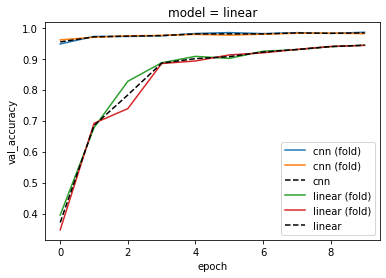

In [13]:
fig, ax = plt.subplots()
for name, g in xdata.groupby("model"):
    g.val_accuracy[:, 0].plot.line(x="epoch", label=f"{name} (fold)", ax=ax)
    g.val_accuracy[:, 0].mean("fold").plot.line(
        x="epoch", label=name, ax=ax, linestyle="--", color="k"
    )
plt.legend()


## Robustness Curve

Now that we have trained some models let's evalulate robustness of each model to adversarial perturbations.  To create a configuration and workflow we need to provide the following for our task:

- The experiment directory containing the experiment parameters and model checkpoint for training
- The perturbation type and perturbation magnitude (`epsilon`)

Below we define a function that extracts the configuration of the model defined by in the experiment YAML file while the checkpoint is found within the training experiment directory.  This makes sure we load the correct model configuration and checkpoint for testing.

In [19]:
def load_model_from_experiment(job_dir: Union[Path, str]):
    # Load configuration for experiment
    job_dir = Path(job_dir)
    exp_cfg = job_dir / ".hydra/config.yaml"
    assert exp_cfg.exists()
    exp_cfg = load_from_yaml(exp_cfg)
    model = instantiate(exp_cfg.model)

    # get path to model checkpoint in experiment directory
    # and load to model
    ckpts = list(job_dir.glob("**/*.ckpt"))
    assert len(ckpts) == 1
    ckpt = ckpts[0]
    load_from_checkpoint(
        model,
        ckpt=ckpt,
        weights_key="state_dict",
        weights_key_strip="model.",
    )

    return model


Now we can define our experiment configuration file.

In [20]:
TestConfig = make_config(
    defaults=[
        "_self_",
        {"optimizer": "l2pgd"},
    ],
    data_dir="${oc.env:HOME}/.torch/data",
    job_dir=MISSING,  # will be auto-populated by our workflow
    trainer=TrainerCfg,
    module=EvalPLModule,
    model=builds(load_model_from_experiment, job_dir="${job_dir}"),
    perturber=Perturber,
    optimizer=MISSING,
    epsilon=0.0,
    steps=10,
)


The workflow inherits from [RobustnessCurve](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.RobustnessCurve.html).  Other than the basic task function to use [Trainer.test](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and return the test metrics saved by [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html), this workflow extends the basic interface for `RobustnessCurve` to:

- Load and correlate the training experiment parameters model and fold to the robustness curve experiments
- Update the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with the training experiment parameters

In [16]:
class ExperimentRobustnessCurve(RobustnessCurve):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.test(module)
        return tr.load("test_metrics.pt")

Run the experiment by first defining the main experiment directory for each cross-validation experiment and providing the `epsilon` values for the calculating the $\ell_2$ adverarial perturbations.

In [21]:
robustness_curve_task = ExperimentRobustnessCurve(TestConfig)
robustness_curve_task.run(
    epsilon=[0, 1, 2],
    target_job_dirs=kfold_task.multirun_working_dirs,
    overrides=[
        "hydra.sweep.dir=outputs/robustness_curves/${now:%Y-%m-%d}/${now:%H-%M-%S}"
    ],
)

## You can load an old experiment
# robustness_curve_task = ExperimentRobustnessCurve().load_from_dir("outputs/robustness_curves/2022-05-11/14-45-02")


[2022-05-13 18:20:31,595][HYDRA] Launching 12 jobs locally
[2022-05-13 18:20:31,595][HYDRA] 	#0 : epsilon=0 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:31,690][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.960099995136261
  test_adversarial_loss     0.12364722788333893
   test_clean_accuracy       0.960099995136261
        test_loss           0.12364724278450012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:33,112][HYDRA] 	#1 : epsilon=0 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:33,209][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9864000082015991
  test_adversarial_loss     0.04095040634274483
   test_clean_accuracy      0.9864000082015991
        test_loss          0.040950410068035126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:35,175][HYDRA] 	#2 : epsilon=0 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:35,273][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9627000093460083
  test_adversarial_loss     0.12427180260419846
   test_clean_accuracy      0.9627000093460083
        test_loss           0.12427180260419846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:36,677][HYDRA] 	#3 : epsilon=0 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:36,773][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9857000112533569
  test_adversarial_loss    0.040786076337099075
   test_clean_accuracy      0.9857000112533569
        test_loss           0.04078606888651848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:38,720][HYDRA] 	#4 : epsilon=1 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:38,817][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.25429999828338623
  test_adversarial_loss     3.1336989402770996
   test_clean_accuracy       0.960099995136261
        test_loss           3.1336989402770996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:40,136][HYDRA] 	#5 : epsilon=1 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:40,236][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.09880000352859497
  test_adversarial_loss      4.911465167999268
   test_clean_accuracy      0.9864000082015991
        test_loss            4.911465167999268
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:42,173][HYDRA] 	#6 : epsilon=1 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:42,276][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/6/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.2134000062942505
  test_adversarial_loss     3.3395023345947266
   test_clean_accuracy      0.9627000093460083
        test_loss           3.3395028114318848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:43,690][HYDRA] 	#7 : epsilon=1 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:43,787][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/7/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.11240000277757645
  test_adversarial_loss      4.659071922302246
   test_clean_accuracy      0.9857000112533569
        test_loss            4.659071922302246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:45,733][HYDRA] 	#8 : epsilon=2 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:45,832][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/8/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.00800000037997961
  test_adversarial_loss     10.397013664245605
   test_clean_accuracy       0.960099995136261
        test_loss           10.397013664245605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:47,178][HYDRA] 	#9 : epsilon=2 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:47,274][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.0
  test_adversarial_loss     17.151403427124023
   test_clean_accuracy      0.9864000082015991
        test_loss           17.151405334472656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:49,221][HYDRA] 	#10 : epsilon=2 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:49,320][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/10/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.00430000014603138
  test_adversarial_loss     10.642273902893066
   test_clean_accuracy      0.9627000093460083
        test_loss           10.642273902893066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-13 18:20:50,693][HYDRA] 	#11 : epsilon=2 job_dir=/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-13 18:20:50,877][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-13/18-08-27/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30/11/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy        0.0003000000142492354
  test_adversarial_loss      16.9349308013916
   test_clean_accuracy      0.9857000112533569
        test_loss            16.9349308013916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [22]:
robustness_curve_task.working_dir

PosixPath('/home/ry26099/public-responsible-ai-toolbox/docs/source/tutorials/outputs/robustness_curves/2022-05-13/18-20-30')

Extract the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [23]:
rdata = robustness_curve_task.to_xarray()
rdata

<xarray.Dataset>
Dimensions:                (epsilon: 3, job_dir: 4)
Coordinates:
  * epsilon                (epsilon) int64 0 1 2
  * job_dir                (job_dir) <U112 '/home/ry26099/public-responsible-...
    fold                   (job_dir) int64 0 0 1 1
    model                  (job_dir) <U6 'linear' 'cnn' 'linear' 'cnn'
Data variables:
    test_clean_accuracy    (epsilon, job_dir) float64 0.9601 0.9864 ... 0.9857
    test_adversarial_loss  (epsilon, job_dir) float64 0.1236 0.04095 ... 16.93
    test_loss              (epsilon, job_dir) float64 0.1236 0.04095 ... 16.93
    test_accuracy          (epsilon, job_dir) float64 0.9601 0.9864 ... 0.0003

And lastly plot the curves for each cross-validation experiment along with the mean curve for each model.

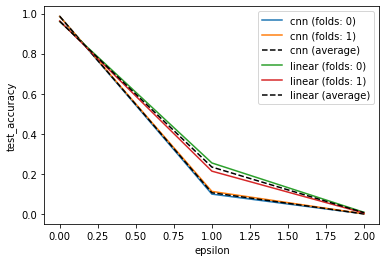

In [25]:
fig, ax = plt.subplots()
for name, g in rdata.groupby("model"):
    for fold, gf in g.groupby("fold"):
        gf.test_accuracy.plot.line(x="epsilon", label=f"{name} (folds: {fold})", ax=ax)
    g.test_accuracy.mean("job_dir").plot.line(
        x="epsilon", label=f"{name} (average)", ax=ax, linestyle="--", color="k"
    )

plt.legend()


That's it! Workflows have the potential to help scale experiments while easily allowing one to load and evalulate results.